In [2]:
import scanpy as sc
import pandas as pd
import sys

In [3]:
import echidna as ec
import matplotlib.pyplot as plt
import torch
from scipy.stats import linregress
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import ListedColormap
ec.pl.activate_plot_settings()

In [28]:
def get_binned_DNA_orig(adata, DNA, map, eta):
  barcodes = list(adata.obs_names)
  for i in range(len(barcodes)):
    barcodes[i] = barcodes[i].split("_")[0]
  barcodes_overlap = set(barcodes).intersection(set(DNA.columns))

  DNA = DNA[barcodes]
  DNA = DNA / np.array(DNA).mean(axis=0) * 2 # THIS STEP IS DESCRIBED IN THE PUBLISHED PAPER THIS DATA CAME FROM


  eta_df = pd.DataFrame(eta.cpu().detach().numpy())
  eta_df.columns = adata.var_names

  DNA_clus = pd.DataFrame()
  for cluster in eta_df.index:
    DNA_cluster = []
    obs = adata.obs
    for i in range(len(obs['leiden'].unique())):
        #inds = obs[obs["leiden"]==str(i)].index
        inds = obs[obs["leiden"]==i].index
        inds = [i.split("_")[0] for i in inds]
        DNA_cluster.append(list(DNA[inds].mean(axis=1)))

    DNA_cluster = pd.DataFrame(DNA_cluster)

    gene_names = []
    W1 = []
    for i in range(DNA_cluster.shape[1]):
        genes = str.split(map.iloc[i]["genes"],",")
        gene_names+=genes
        W1+=[DNA_cluster.loc[cluster][i] for j in range(len(genes))]

    DNA_clus[cluster] =  W1
  DNA_clus.index = gene_names
  return DNA_clus, DNA_cluster

In [29]:
# helper function for binning
def binning_eta(df):
    binned = []
    discard_bins = []
    for id, row in map.iterrows():
        genes = str.split(row['genes'],",")
        overlap = list(set(df.columns).intersection(set(genes)))
        in_bin = df[overlap]
        if np.array(in_bin).shape[1] == 0:
            discard_bins.append(id)
            continue
        bin_col = np.array(in_bin).mean(axis=1)
        binned.append(bin_col.reshape(-1, 1))
    binned = np.concatenate(binned, axis=1)
    return binned, discard_bins

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.stats import entropy, ttest_ind
from collections import Counter

def compute_purity(ground_truth, predicted):
    """Compute Purity Score"""
    contingency_matrix = pd.crosstab(ground_truth, predicted)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

def bootstrap_metric(ground_truth, predicted, metric_func, n_bootstrap=100):
    """Compute bootstrapped mean and standard deviation for a given metric."""
    bootstrap_scores = []
    n = len(ground_truth)
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace=True)
        score = metric_func(ground_truth[indices], predicted[indices])
        bootstrap_scores.append(score)
    return np.mean(bootstrap_scores), np.std(bootstrap_scores)

def evaluate_clustering_metrics(adata, ground_truth_label, labels):
    """Compute clustering metrics for labels in an AnnData object."""
    metrics = {}
    for label in labels:
        ground_truth = adata.obs[ground_truth_label].values
        predicted = adata.obs[label].values

        purity_mean, purity_std = bootstrap_metric(ground_truth, predicted, compute_purity)
        nmi_mean, nmi_std = bootstrap_metric(ground_truth, predicted, normalized_mutual_info_score)
        ami_mean, ami_std = bootstrap_metric(ground_truth, predicted, adjusted_mutual_info_score)
        ari_mean, ari_std = bootstrap_metric(ground_truth, predicted, adjusted_rand_score)

        metrics[label] = {
            'Purity': (purity_mean, purity_std),
            'NMI': (nmi_mean, nmi_std),
            'AMI': (ami_mean, ami_std),
            'ARI': (ari_mean, ari_std)
        }
    return pd.DataFrame(metrics).T

def evaluate_regression_metrics(Xs, Ys, models):
    """Compute regression metrics."""
    metrics = {}
    for i, x, y in enumerate(zip(Xs, Ys)):
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        label = models[i]
        metrics[label] = {'PearsonR': r_value}
    return pd.DataFrame(metrics).T

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Tab10: blue, orange, green, red, purple …
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],   # blue
    "inferCNV":  plt.cm.tab10.colors[1],   # orange
    "numbat":    plt.cm.tab10.colors[2],   # green
    "CopyKAT":   plt.cm.tab10.colors[3],   # red
    "XClone":    plt.cm.tab10.colors[4],   # purple
    "XClone_allele": plt.cm.tab10.colors[5],  # brown
}

def _star(p):
    if p < 1e-10:
        return '***'
    if p < 1e-5:
        return '**'
    if p < 0.05:
        return '*'
    return ''

def plot_metric_bar(ax, metric, data, dataset_name, orientation="vertical"):
    """
    Plot a metric for echidna / inferCNV / numbat / CopyKAT / XClone / XClone_allele.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    metric : str
        Column name holding (mean, err) tuples.
    data : pd.DataFrame
        Index must contain '<tool>_clones' rows with (mean, err) tuples in `metric`.
    dataset_name : str or list-like
        Still accepted (e.g. for a title), but no longer used to set x‑ticks.
    orientation : "vertical" | "horizontal"
    """
    tools   = ["echidna", "inferCNV", "numbat", "CopyKAT", "XClone", "XClone_allele"]
    rows    = [f"{t}_clones" for t in tools]

    # ------------------------------------------------------------------ #
    # pull values
    # ------------------------------------------------------------------ #
    means, errs = [], []
    for r in rows:
        m, e = data.loc[r, metric] if r in data.index else (0.0, 0.0)
        means.append(m); errs.append(e)

    # sort high → low
    order  = np.argsort(means)[::-1]
    means  = [means[i]  for i in order]
    errs   = [errs[i]   for i in order]
    labels = [tools[i]  for i in order]

    n_bars = len(labels)
    x      = np.arange(n_bars)
    width  = 0.6

    if orientation == "horizontal":
        # one bar per method down the y‑axis
        for j in range(n_bars):
            ax.barh(x[j], means[j], height=width,
                    xerr=errs[j], alpha=0.7,
                    color=_COLOR_MAP[labels[j]])

        ax.set_yticks(x)
        ax.set_yticklabels(labels, fontsize=18)          # method names here
        ax.set_xlabel(metric, fontsize=20)
        ax.tick_params(axis="x", labelsize=18)           # larger tick labels
        ax.grid(True, axis="x", linestyle="--", alpha=0.6)

        # significance stars (vs. best bar)
        ref = np.random.normal(means[0], errs[0], 100)
        max_x = max(m + e for m, e in zip(means, errs))
        for j in range(1, n_bars):
            comp  = np.random.normal(means[j], errs[j], 100)
            star  = _star(ttest_ind(ref, comp).pvalue)
            if star:
                y_pos = x[j]
                x_pos = means[j] + errs[j] + 0.02 * max_x
                ax.text(x_pos, y_pos, star, va='center', ha='left', fontsize=12)

        ax.set_xlim(0, max_x + 0.3)

    # ------------------------------------------------------------------ #
    # vertical bars (default)
    # ------------------------------------------------------------------ #
    else:
        for j in range(n_bars):
            ax.bar(x[j], means[j], width,
                   yerr=errs[j], alpha=0.7,
                   color=_COLOR_MAP[labels[j]])

        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=18, rotation=90)  # method names here
        ax.set_ylabel(metric, fontsize=20)
        ax.tick_params(axis="y", labelsize=18)                # bigger y‑tick numbers
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)

        # significance stars (vs. best bar)
        ref   = np.random.normal(means[0], errs[0], 100)
        max_y = max(m + e for m, e in zip(means, errs))
        for j in range(1, n_bars):
            comp = np.random.normal(means[j], errs[j], 100)
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                x_pos = x[j]
                y_pos = means[j] + errs[j] + 0.02 * max_y
                ax.text(x_pos, y_pos, star, ha='center', va='bottom', fontsize=12)

        ax.set_ylim(0, max_y + 0.3)

# Tumor 2 clone calling

In [32]:
tumor2 = sc.read_h5ad("data/tumor2/Tumor2_X.h5ad")
#tumor2 = sc.read_h5ad("data/tumor5/Tumor5_X.h5ad")
tumor2

AnnData object with n_obs × n_vars = 2337 × 29639
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [33]:
wdf_tumor2 = pd.read_csv("/home/mingxuanzhang/echidna/data/tumor2/tumor2_processed_w.csv",
                         names=["index", "gene", "counts"],
                         header=0,).set_index("gene").drop("index", axis=1)
# wdf_tumor2 = pd.read_csv("/home/mingxuanzhang/echidna/data/tumor5/tumor5_processed_w.csv",
#                          names=["index", "gene", "counts"],
#                          header=0,).set_index("gene").drop("index", axis=1)
wdf_tumor2.head()

,counts
gene,
MIR1302-2HG,1.06135
FAM138A,1.06135
OR4F5,1.06135
AL627309.1,1.06135
AL627309.3,1.06135


In [34]:
def cleaning_ST(adata, wdf):
  matched_genes = adata.var.index.intersection(wdf.index)
  wdf = wdf.loc[matched_genes]
  adata = adata[:, matched_genes]
  wdf = wdf.loc[~wdf.index.duplicated(keep=False)]
  adata = adata[:, wdf.index]
  adata.obs["timepoint"] = "single_tp"
  return adata, wdf

In [35]:
tumor2, wdf_tumor2 = cleaning_ST(tumor2, wdf_tumor2)

/var/tmp/ipykernel_32590/2319707466.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["timepoint"] = "single_tp"


In [36]:
adata = tumor2
num_cells = adata.shape[1]
num_genes = adata.shape[-1]
num_clusters = len(adata.obs['leiden'].unique())
q_corr_init = 0.1
q_shape_rate_scaler = 10.0
eta_mean_init = wdf_tumor2['counts'].mean()
lkj_concentration = 1.0

In [37]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    num_cells=num_cells,
    num_genes=num_genes,
    num_clusters=num_clusters,
    inverse_gamma = True, # Inverse Gamma can be more stable in low data settings
    eta_mean_init = eta_mean_init, # Our genes average approximately two copies
    q_corr_init=q_corr_init,
    q_shape_rate_scaler=q_shape_rate_scaler,
    lkj_concentration=lkj_concentration,
    patience = -1, # turn off early stopping
    n_steps = 500, # Passes through the dataset
)

2025-07-22 02:41:04,745 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 233 cells in validation set.
2025-07-22 02:41:04,751 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2025-07-22 02:41:04,756 | INFO : Added `.var[echidna_W_counts]` : CN entries for genes contained in W.
2025-07-22 02:41:04,757 | WARNING : `leiden` changed to `leiden_categorical`.
/home/mingxuanzhang/echidna/echidna/tools/train.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 3 3 ... 8 1 7]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  adata.obs.loc[:, config.clusters] = pd.Categorical(adata.obs.loc[:,config.clusters]).codes
training loss: 0.1458 | validation loss: 0.0272: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.78it/s]


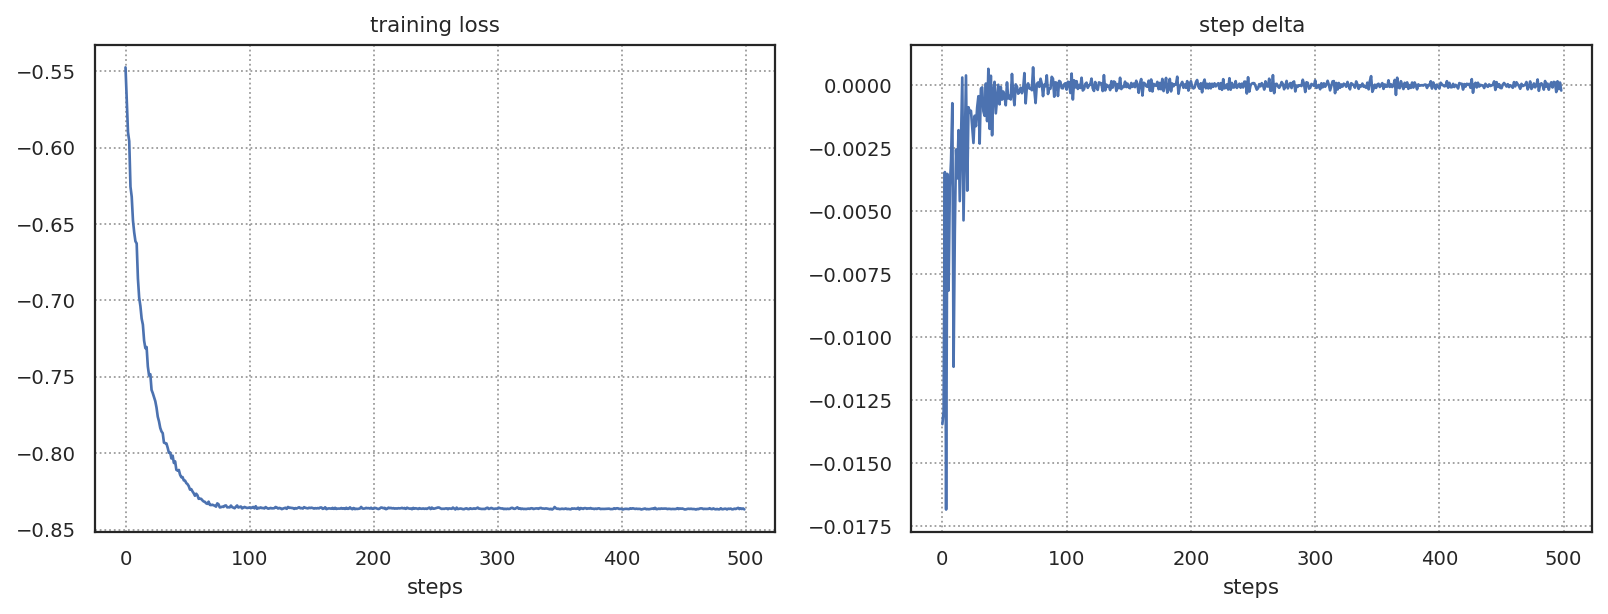

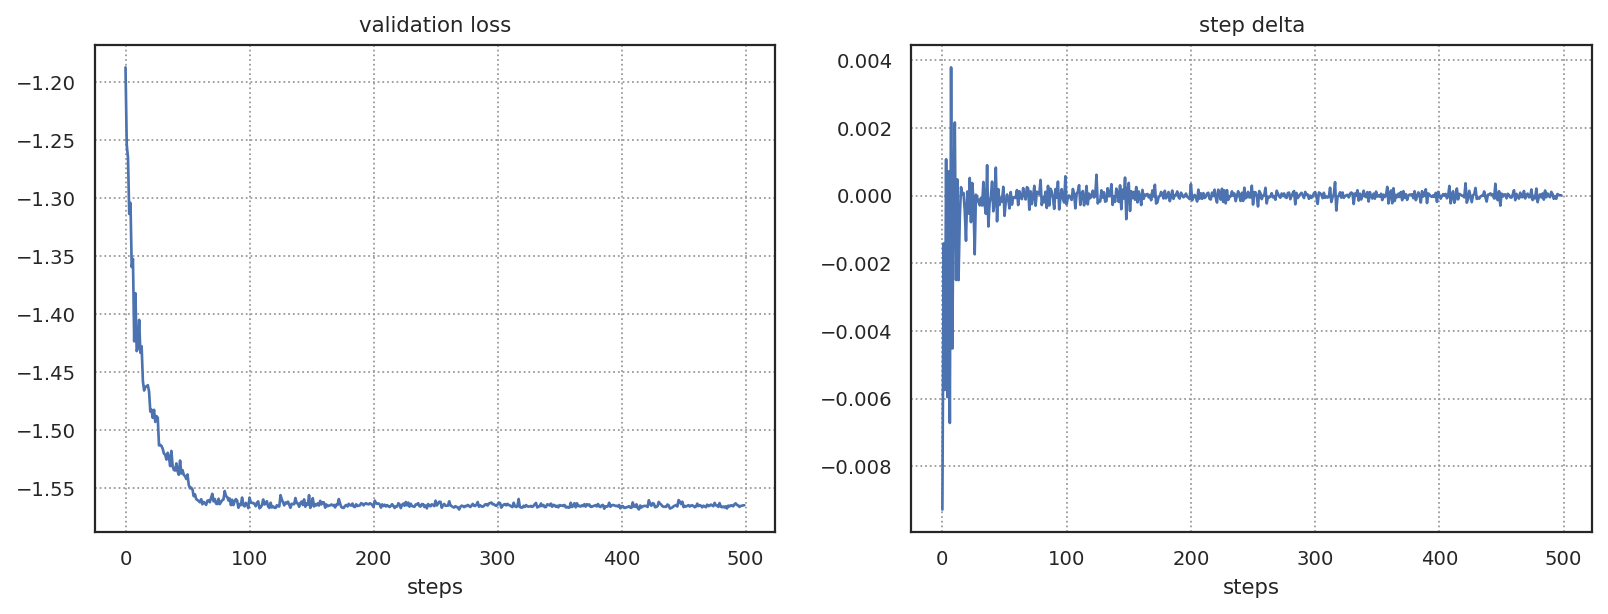

2025-07-22 02:41:58,054 | INFO : Saving echidna model with run_id 20250722-024158.


In [38]:
ec.tl.echidna_train(
     adata # single cell anndata
    , wdf_tumor2.loc[:,"counts"] # Copy number pd.DataFrame, indexed with genes. Select for "on" timepoint.
    , config # config settings
)

In [39]:
ec.tl.echidna_clones(adata, method='manual', metric="smoothed_corr", threshold=0.3)

/home/mingxuanzhang/echidna/echidna/tools/eval.py:375: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-07-22 02:41:58,981 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


... storing 'timepoint' as categorical


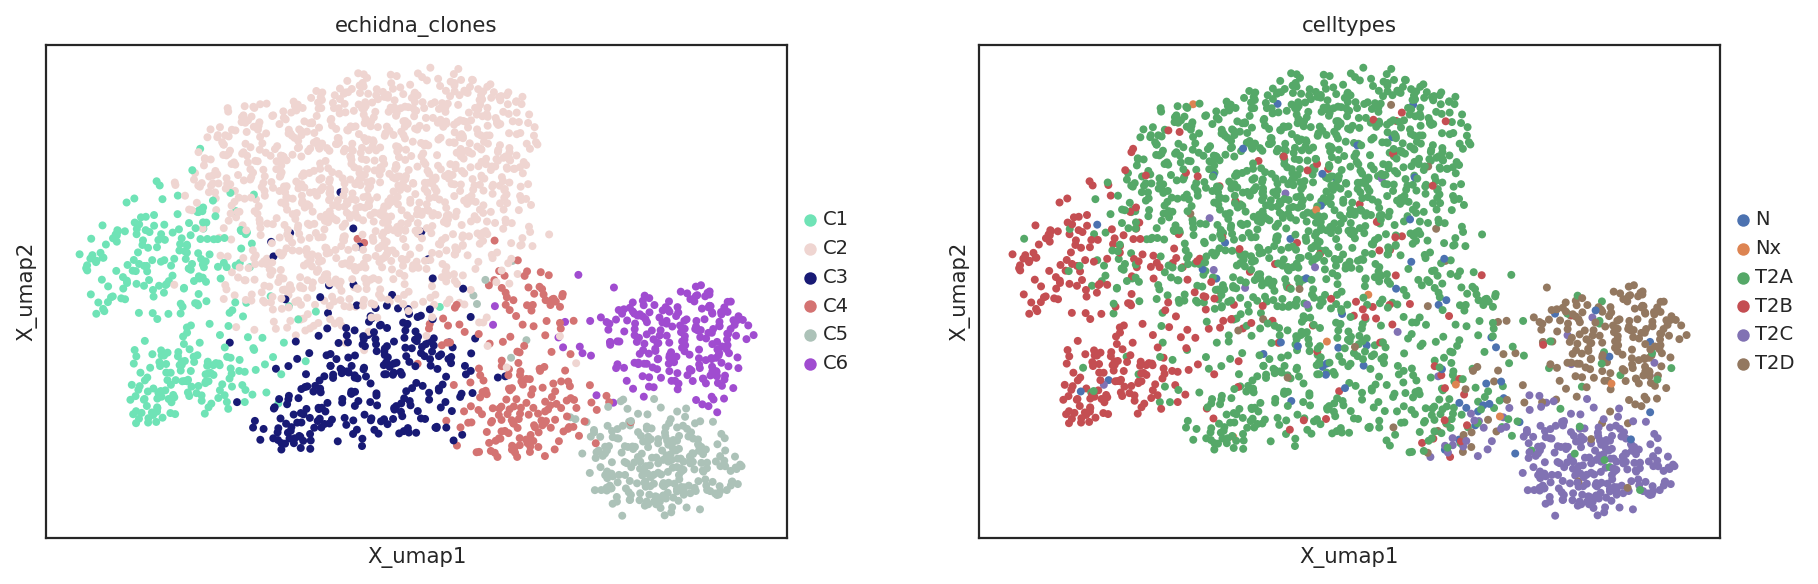

In [40]:
ec.pl.echidna(adata, ["echidna_clones", "celltypes"])

In [41]:
tumor2 = adata.copy()
tumor2.obs['barcode_infercnv'] = [i.split("_")[0] for i in tumor2.obs_names]
tumor2.obs['barcode_numbat'] = [i.split("_")[0][:-1] for i in tumor2.obs_names]
tumor2.obs['barcode_orig'] = tumor2.obs_names
tumor2

AnnData object with n_obs × n_vars = 2337 × 18675
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'timepoint', 'echidna_split', 'leiden_categorical', 'echidna_clones', 'barcode_infercnv', 'barcode_numbat', 'barcode_orig'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'echidna_matched_genes', 'echidna_W_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'echidna', 'echidna_clones_colors', 'celltypes_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [42]:
ec_model = ec.tl.load_model(tumor2,
                            save_folder="/home/mingxuanzhang/echidna/model_tumor2",
                            model_config=config)
eta_tumor2 = ec_model.eta_posterior

In [43]:
len(tumor2.obs['leiden'].unique())

10

In [44]:
DNA_tumor2 =  pd.read_csv("/home/mingxuanzhang/echidna/data/tumor2/DNA_bin_counts_matrix.txt", sep='\t')
map = pd.read_csv("/home/mingxuanzhang/echidna/data/bin-boundaries and genes.txt",sep='\t')
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_binned, discard_bins = binning_eta(eta_df_tumor2)
_, DNA_cluster = get_binned_DNA_orig(tumor2, DNA_tumor2, map, eta_tumor2)
valid_bins = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster = DNA_cluster[valid_bins]

In [45]:
DNA_cluster

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,2.587798,2.886495,2.005488,2.383187,2.041201,2.164904,2.214401,2.230466,2.645158,2.202723,...,2.055383,2.040276,2.699714,2.175498,1.914041,2.278934,2.700728,2.127516,1.214204,1.486777
1,2.455456,2.983377,2.001624,2.495571,2.157724,2.105547,2.308037,2.136039,2.349191,2.218938,...,2.126433,2.112650,2.739667,2.099360,2.056834,2.205085,2.920238,2.210749,1.260158,1.588785
2,2.592613,2.679372,2.020204,2.483375,2.103293,2.061808,2.415059,2.262017,2.372682,2.312046,...,2.347760,2.214464,2.854585,2.302923,2.180495,2.249975,2.513198,2.332202,1.329168,1.619016
3,2.488511,2.946498,2.021058,2.456916,2.030953,2.157887,2.317076,2.243370,2.517878,2.335649,...,2.074655,2.039708,2.853072,2.080610,1.992174,2.215392,2.659193,2.134018,1.268604,1.489175
4,1.683464,1.431446,1.613348,2.491993,2.092861,2.069679,2.411744,2.254237,2.377740,2.346368,...,2.276026,2.204184,3.001759,2.272607,2.122295,2.266150,2.590491,2.365384,1.214817,1.590120
5,1.624227,1.494440,1.420588,2.207119,1.976791,1.874944,2.005459,1.293581,1.335141,1.318433,...,2.333771,2.133857,3.075027,2.074349,1.909249,2.087975,2.339959,2.512648,1.186727,1.631151
6,2.339710,2.198493,1.837915,2.378183,2.064699,2.071444,2.293750,2.142072,2.112015,2.127316,...,2.287136,2.237845,3.016453,2.235690,2.108261,2.200324,2.439834,2.305453,1.366798,1.596204
7,2.487174,2.879942,2.170689,2.558009,2.185589,2.014815,2.373179,2.332551,2.411921,2.291988,...,2.154464,2.295844,2.979804,2.127649,1.999201,2.286987,2.898356,2.398089,1.731597,1.855907
8,2.586629,2.871282,2.419873,2.574250,2.224162,2.068847,2.422074,2.376216,2.528954,2.478362,...,2.138312,2.105384,2.914309,2.174701,2.224253,2.378098,2.977745,2.666874,1.751466,2.073667
9,2.413531,2.691155,1.930745,2.459397,2.161623,2.145172,2.305472,2.197487,2.450192,2.364566,...,2.103317,2.050828,2.622898,2.233072,2.039096,2.252687,2.791126,2.117678,1.240366,1.378240


In [21]:
#np.save("/home/mingxuanzhang/echidna/benchmarking_data/echidna_binned_tumor5.npy", eta_binned)

In [22]:
#np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_echidna_tumor5.npy", DNA_cluster.values)

## InferCNV

In [23]:
infercnv = pd.read_csv('/home/mingxuanzhang/echidna/benchmarking_data/infercnv_tumor2', index_col=0)
infercnv.head()

,AAACATAAAGATGTATG1,AAACATAACTTTCAATA1,AAACATAGAACCGGTTG1,AAACATCGACTTTTACC1,AAACATCTTGGCTCAAG1,AAACATGTTACTCGAAT1,AAACATGTTCCCCGTTC1,AAACATTTCCCAAATGC1,AAACCGAAACTTTATGA1,AAACCGAAAGTACAACG1,...,TTTTATTAATTTCGTGA2,TTTTATTAATTTGATGT2,TTTTATTAGCCTGGATT2,TTTTATTCTTCAAGATC2,TTTTATTGAGGTAGATC2,TTTTATTGGCGAAGATC2,TTTTATTGTTAACTATC2,TTTTATTTCGGCATACG2,TTTTATTTGACTATTAA2,TTTTATTTTACGACTAG2
chr1.WASH7P,1.000167,1.042003,1.048645,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,...,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167
chr1.LOC100133331,1.000167,1.039827,1.048653,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,...,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167
chr1.LOC100288069,1.000167,1.037845,1.048710,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,...,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167
chr1.LINC00115,1.000167,1.036021,1.048797,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,...,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167
chr1.SAMD11,1.000167,1.034348,1.048927,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,...,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167,1.000167


In [24]:
infercnv.index = infercnv.index.str.split('.').str[-1]
infercnv = infercnv.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(infercnv.index)
columns = tumor2.var.index.intersection(infercnv.T.index)
X_ = tumor2[rows, columns]
infercnv = infercnv.loc[rows, columns]
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, infercnv.shape, eta_df_tumor2.shape)

(2337, 9529) (2337, 9529) (10, 9529)


In [25]:
X_.X = infercnv
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [26]:
infercnv_binned, discard_bins = binning_eta(cnv_df)
valid_bins_infercnv = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_infercnv = DNA_cluster[valid_bins_infercnv]

In [27]:
from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(infercnv_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [28]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['inferCNV_clones'] = leiden_clusters.map(leiden_to_kmeans)

## Numbat

In [29]:
numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
numbat_bulk = numbat_bulk.dropna() # COMMENT OUT FOR TUMOR 5, FOR TUMOR 2 RUN THIS LINE
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]

/var/tmp/ipykernel_23143/1716007609.py:1: DtypeWarning: Columns (29,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')


In [30]:
gene_cnv = (numbat_bulk
            .groupby(['sample', 'gene'], as_index=False)
            .agg(median_phi_mle=('phi_mle', 'median')))
gene_cnv['est_cn'] = gene_cnv['median_phi_mle']
clone_by_gene = gene_cnv.pivot(index='sample', columns='gene', values='est_cn')
clone_by_gene.fillna(1.0, inplace=True) # neutral is 1.0
clone_by_gene.loc[1] = [1.0] * len(clone_by_gene.columns)
clone_by_gene.index.names = ['clone_opt'] # clone 1 is assigned as normal cells

In [31]:
numbat_clones = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
tumor2.obs_names = tumor2.obs['barcode_numbat']
overlapping_barcodes = set(list(tumor2.obs_names)).intersection(set(list(numbat_clones.index)))
tumor2 = tumor2[tumor2.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(tumor2.obs_names)
tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)

/var/tmp/ipykernel_23143/2028230267.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)


## Copykat

In [32]:
copykat = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/copykat_tumor2/t2_r1_copykat_CNA_raw_results_gene_by_cell.txt", sep='\t')
copykat = copykat.set_index('hgnc_symbol')
copykat.head()

,abspos,chromosome_name,start_position,end_position,ensembl_gene_id,band,AAACATAAAGATGTATG1,AAACATAACTTTCAATA1,AAACATCGACTTTTACC1,AAACATCTTGGCTCAAG1,...,TTTTATTAATTTCGTGA2,TTTTATTAATTTGATGT2,TTTTATTAGCCTGGATT2,TTTTATTCTTCAAGATC2,TTTTATTGAGGTAGATC2,TTTTATTGGCGAAGATC2,TTTTATTGTTAACTATC2,TTTTATTTCGGCATACG2,TTTTATTTGACTATTAA2,TTTTATTTTACGACTAG2
hgnc_symbol,,,,,,,,,,,,,,,,,,,,,
WASH7P,21987,1,14404,29570,ENSG00000227232,p36.33,-0.030895,0.001436,0.003083,0.050383,...,0.00233,0.083771,0.079092,0.045937,0.011576,0.03626,0.029469,-0.010632,0.050809,0.002807
KLHL17,963151,1,960587,965715,ENSG00000187961,p36.33,-0.030895,0.001436,0.003083,0.050383,...,0.00233,0.083771,0.079092,0.045937,0.011576,0.03626,0.029469,-0.010632,0.050809,0.002807
AGRN,1038120,1,1020123,1056118,ENSG00000188157,p36.33,-0.030895,0.001436,0.003083,0.050383,...,0.00233,0.083771,0.079092,0.045937,0.011576,0.03626,0.029469,-0.010632,0.050809,0.002807
C1orf159,1099089,1,1081818,1116361,ENSG00000131591,p36.33,-0.030895,0.001436,0.003083,0.050383,...,0.00233,0.083771,0.079092,0.045937,0.011576,0.03626,0.029469,-0.010632,0.050809,0.002807
INTS11,1318138,1,1311585,1324691,ENSG00000127054,p36.33,-0.030895,0.001436,0.003083,0.050383,...,0.00233,0.083771,0.079092,0.045937,0.011576,0.03626,0.029469,-0.010632,0.050809,0.002807


In [33]:
copykat.shape

(2967, 2939)

In [34]:
copykat = copykat.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(copykat.index)
columns = tumor2.var.index.intersection(copykat.T.index)
print(len(rows), len(columns))
X_ = tumor2[rows, columns]
copykat = copykat.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, copykat.shape, eta_df_tumor2.shape)

2063 2384
(2063, 2384) (2063, 2384) (10, 2384)


In [35]:
X_.X = copykat
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [36]:
copykat_binned, discard_bins = binning_eta(cnv_df)
valid_bins_copykat = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_copykat = DNA_cluster[valid_bins_copykat]

In [37]:
from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(copykat_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [38]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['CopyKAT_clones'] = leiden_clusters.map(leiden_to_kmeans)

In [39]:
tumor2.obs['ground_truth_clones'] = tumor2.obs['celltypes']

## XClone

In [22]:
xclone = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/xlcone_tumor2/data/RDR_adata_KNN_HMM_post.h5ad")
xclone

AnnData object with n_obs × n_vars = 3641 × 3287
    obs: 'Type', 'cell_type', 'obs_names', 'counts_ratio'
    var: 'GeneName', 'arm', 'band', 'chr', 'chr_arm', 'gieStain', 'start', 'stop', 'var_names', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'RDR_smooth', 'posterior_mtx', 'posterior_mtx_log', 'raw_expr'
    obsp: 'connectivities', 'distances'

In [23]:
xclone.var['genes'] = [g.split(".")[-1] for g in list(xclone.var['GeneName'])]
xclone.var['genes']

5            ABL2
8           ACBD3
13           ACP6
22       ADAMTSL4
23           ADAR
           ...   
21516         ZFX
21518       ZMAT1
21519       ZMYM3
21535     AKAP17A
21544        CD24
Name: genes, Length: 3287, dtype: object

In [24]:
from sklearn.preprocessing import StandardScaler
state_score = np.array([-1, 0, 1], dtype=float)
post = xclone.layers['posterior_mtx'].copy()
scores = np.tensordot(post, state_score, axes=(-1, 0))
#H = -(post * np.log(post + 1e-12)).sum(-1)
#input_mat = np.hstack([scores, H])
input_mat = scores
input_mat = StandardScaler().fit_transform(input_mat)
input_mat.shape

(3641, 3287)

In [25]:
xclone = pd.DataFrame(input_mat, index=xclone.obs['obs_names'], columns=xclone.var['genes'])
xclone

genes,ABL2,ACBD3,ACP6,ADAMTSL4,ADAR,ADGRL2,AGL,AGO1,AGO3,AGRN,...,UBQLN2,USP9X,WDR13,WWC3,XIAP,ZFX,ZMAT1,ZMYM3,AKAP17A,CD24
obs_names,,,,,,,,,,,,,,,,,,,,,
AAACATAAAGATGTATG1,1.632560,1.632561,1.632561,1.632561,1.632562,1.632565,1.632567,1.632568,1.632568,1.632570,...,0.987936,0.987929,0.987924,0.987921,0.987917,0.987916,0.987916,0.987916,0.956344,0.672461
AAACATAACTTTCAATA1,-1.024505,-1.024506,-1.024506,-1.024506,-1.024505,-1.024505,-1.024505,-1.024504,-1.024504,-1.024503,...,-0.110392,-0.110391,-0.110392,-0.110393,-0.110395,-0.110396,-0.110396,-0.110397,-0.032428,-0.380494
AAACATAGAACCGGTTG1,-0.353874,-0.353874,-0.353874,-0.353873,-0.353872,-0.353872,-0.353871,-0.353871,-0.353871,-0.353871,...,0.249127,0.249128,0.249129,0.249130,0.249133,0.249133,0.249133,0.249132,0.662693,-0.225231
AAACATCGACTTTTACC1,-1.410815,-1.410817,-1.410819,-1.410820,-1.410824,-1.410827,-1.410832,-1.410838,-1.410845,-1.410851,...,0.772435,0.772432,0.772430,0.772428,0.772425,0.772423,0.772422,0.772421,-0.341386,-0.867380
AAACATCTTGGCTCAAG1,1.060482,1.060483,1.060482,1.060482,1.060482,1.060480,1.060479,1.060477,1.060477,1.060476,...,-0.839764,-0.839765,-0.839766,-0.839768,-0.839769,-0.839770,-0.839771,-0.839771,-0.724541,0.846270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTATTGGCGAAGATC2,-0.857841,-0.857840,-0.857840,-0.857839,-0.857838,-0.857836,-0.857834,-0.857832,-0.857830,-0.857828,...,1.116536,1.116541,1.116546,1.116550,1.116551,1.116552,1.116554,1.116556,-0.049621,-0.782171
TTTTATTGTTAACTATC2,-1.917065,-1.917064,-1.917064,-1.917064,-1.917064,-1.917063,-1.917061,-1.917059,-1.917057,-1.917056,...,1.357313,1.357311,1.357307,1.357305,1.357302,1.357301,1.357300,1.357299,1.015124,-0.802075
TTTTATTTCGGCATACG2,-2.960788,-2.960787,-2.960787,-2.960785,-2.960783,-2.960782,-2.960779,-2.960776,-2.960773,-2.960769,...,0.175573,0.175577,0.175578,0.175578,0.175577,0.175574,0.175573,0.175572,2.233213,-0.677970


In [26]:
xclone.T

obs_names,AAACATAAAGATGTATG1,AAACATAACTTTCAATA1,AAACATAGAACCGGTTG1,AAACATCGACTTTTACC1,AAACATCTTGGCTCAAG1,AAACATGTTACTCGAAT1,AAACATGTTCCCCGTTC1,AAACATTTCCCAAATGC1,AAACCGAAACTTTATGA1,AAACCGAAAGTACAACG1,...,TTTTATTAATTTCGTGA2,TTTTATTAATTTGATGT2,TTTTATTAGCCTGGATT2,TTTTATTCTTCAAGATC2,TTTTATTGAGGTAGATC2,TTTTATTGGCGAAGATC2,TTTTATTGTTAACTATC2,TTTTATTTCGGCATACG2,TTTTATTTGACTATTAA2,TTTTATTTTACGACTAG2
genes,,,,,,,,,,,,,,,,,,,,,
ABL2,1.632560,-1.024505,-0.353874,-1.410815,1.060482,1.744112,-0.353821,-1.135051,0.826504,0.429778,...,0.980446,-1.779076,1.267560,-0.575852,-0.448407,-0.857841,-1.917065,-2.960788,1.351554,-0.303393
ACBD3,1.632561,-1.024506,-0.353874,-1.410817,1.060483,1.744113,-0.353820,-1.135053,0.826503,0.429779,...,0.980446,-1.779078,1.267561,-0.575851,-0.448407,-0.857840,-1.917064,-2.960787,1.351555,-0.303395
ACP6,1.632561,-1.024506,-0.353874,-1.410819,1.060482,1.744114,-0.353818,-1.135056,0.826503,0.429780,...,0.980447,-1.779080,1.267561,-0.575850,-0.448405,-0.857840,-1.917064,-2.960787,1.351557,-0.303396
ADAMTSL4,1.632561,-1.024506,-0.353873,-1.410820,1.060482,1.744114,-0.353816,-1.135059,0.826503,0.429781,...,0.980447,-1.779082,1.267562,-0.575848,-0.448404,-0.857839,-1.917064,-2.960785,1.351558,-0.303397
ADAR,1.632562,-1.024505,-0.353872,-1.410824,1.060482,1.744113,-0.353814,-1.135063,0.826504,0.429782,...,0.980449,-1.779083,1.267561,-0.575846,-0.448402,-0.857838,-1.917064,-2.960783,1.351559,-0.303398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFX,0.987916,-0.110396,0.249133,0.772423,-0.839770,0.265107,-0.373422,-0.280980,-1.081402,-0.296567,...,1.470291,-0.383557,-0.582805,-1.668674,-0.445278,1.116552,1.357301,0.175574,-0.387482,0.312225
ZMAT1,0.987916,-0.110396,0.249133,0.772422,-0.839771,0.265109,-0.373417,-0.280980,-1.081399,-0.296568,...,1.470291,-0.383558,-0.582805,-1.668673,-0.445279,1.116554,1.357300,0.175573,-0.387483,0.312224
ZMYM3,0.987916,-0.110397,0.249132,0.772421,-0.839771,0.265112,-0.373418,-0.280980,-1.081396,-0.296569,...,1.470290,-0.383559,-0.582806,-1.668673,-0.445280,1.116556,1.357299,0.175572,-0.387482,0.312224


In [27]:
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(xclone.index)
print(xclone.index)
columns = tumor2.var.index.intersection(xclone.T.index)
X_ = tumor2[rows, columns]
xclone = xclone.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, xclone.shape, eta_df_tumor2.shape)

Index(['AAACATAAAGATGTATG1', 'AAACATAACTTTCAATA1', 'AAACATAGAACCGGTTG1',
       'AAACATCGACTTTTACC1', 'AAACATCTTGGCTCAAG1', 'AAACATGTTACTCGAAT1',
       'AAACATGTTCCCCGTTC1', 'AAACATTTCCCAAATGC1', 'AAACCGAAACTTTATGA1',
       'AAACCGAAAGTACAACG1',
       ...
       'TTTTATTAATTTCGTGA2', 'TTTTATTAATTTGATGT2', 'TTTTATTAGCCTGGATT2',
       'TTTTATTCTTCAAGATC2', 'TTTTATTGAGGTAGATC2', 'TTTTATTGGCGAAGATC2',
       'TTTTATTGTTAACTATC2', 'TTTTATTTCGGCATACG2', 'TTTTATTTGACTATTAA2',
       'TTTTATTTTACGACTAG2'],
      dtype='object', name='obs_names', length=3641)


NameError: name 'eta_tumor2' is not defined

In [ ]:
X_.X = xclone
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [ ]:
xclone_binned, discard_bins = binning_eta(cnv_df)
valid_bins_xclone = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_xclone = DNA_cluster[valid_bins_xclone]

In [48]:
from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(xclone_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [49]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['XClone_clones'] = leiden_clusters.map(leiden_to_kmeans)

# XClone with allele

In [47]:
xclone = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/xlcone_tumor2/data/xclone_tumor2_outputs_combine2_data_combined_final.h5ad")
xclone

AnnData object with n_obs × n_vars = 2806 × 3487
    obs: 'matched_name', 'Type', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'data_mode', 'data_notes', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'genome_mode', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'log', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'WGD_prop', 'X_pca'
    varm: 'PCs'
    layers: 'BAF_extend_post_prob', 'RDR_smooth', 'WGD_bool', 'combine_base_prob', 'corrected_prob', 'plot_prob_merge1', 'plot_prob_merge2', 'plot_prob_merge3', 'plot_prob_merge4', 'posterior_mtx', 'posterior_mtx_log', 'prob1_merge', 'raw_expr', 'rdr_posterior_mtx_denoised'
    obsp: 'connectivities', 'distances'

In [48]:
xclone.var['genes'] = [g.split(".")[-1] for g in list(xclone.var['GeneName'])]
xclone.var['genes']

0        MIR1302-10
1           FAM138A
10           OR4F29
16                4
33           SAMD11
            ...    
32626         TTTY2
32630        TTTY23
32633         USP9Y
32635           UTY
32657        TTTY10
Name: genes, Length: 3487, dtype: object

In [49]:
xclone.layers['prob1_merge'].shape

(2806, 3487, 4)

In [50]:
from sklearn.preprocessing import StandardScaler
state_score = np.array([-1, 0, 1], dtype=float)
post = xclone.layers['posterior_mtx'].copy()
scores = np.tensordot(post, state_score, axes=(-1, 0))
#H = -(post * np.log(post + 1e-12)).sum(-1)
#input_mat = np.hstack([scores, H])
input_mat = scores
input_mat = StandardScaler().fit_transform(input_mat)
input_mat.shape

(2806, 3487)

In [51]:
xclone = pd.DataFrame(input_mat, index=xclone.obs['matched_name'], columns=xclone.var['genes'])
xclone

genes,MIR1302-10,FAM138A,OR4F29,4,SAMD11,AGRN,13,7,TMEM52,HES5,...,TTTY1B,AMELY,LINC00279,TTTY18,TTTY7B,TTTY2,TTTY23,USP9Y,UTY,TTTY10
matched_name,,,,,,,,,,,,,,,,,,,,,
AAACATAAAGATGTATG,0.696358,0.696358,0.696357,0.696357,0.696356,0.696356,0.696356,0.696355,0.696355,0.696354,...,-0.761499,-0.761498,-0.761498,-0.761496,-0.761495,-0.761494,-0.761493,-0.823186,-0.823186,-0.823191
AAACATAAATCCGTTGA,-0.315914,-0.315915,-0.315917,-0.315918,-0.315920,-0.315921,-0.315922,-0.315924,-0.315925,-0.315926,...,0.797965,0.797965,0.797965,0.797965,0.797965,0.797965,0.797965,0.618672,0.618671,0.618671
AAACATAAATCCTGTAA,0.369578,0.369577,0.369576,0.369575,0.369574,0.369573,0.369572,0.369571,0.369570,0.369569,...,0.806658,0.806658,0.806658,0.806658,0.806658,0.806658,0.806658,0.622495,0.622495,0.622495
AAACATAACAAGGGATT,-0.386497,-0.386499,-0.386501,-0.386503,-0.386505,-0.386507,-0.386508,-0.386510,-0.386512,-0.386513,...,0.936781,0.936781,0.936781,0.936782,0.936782,0.936782,0.936781,0.597018,0.597018,0.597018
AAACATAACCTGCATGG,-0.323193,-0.323194,-0.323196,-0.323198,-0.323199,-0.323200,-0.323202,-0.323203,-0.323205,-0.323206,...,0.798947,0.798947,0.798947,0.798947,0.798947,0.798947,0.798947,0.619104,0.619103,0.619103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTATTCTTCAAGATC,-0.693036,-0.693037,-0.693038,-0.693039,-0.693041,-0.693042,-0.693043,-0.693044,-0.693045,-0.693046,...,0.781456,0.781456,0.781456,0.781456,0.781456,0.781456,0.781456,0.611390,0.611390,0.611390
TTTTATTGAGGTAGATC,-0.798343,-0.798343,-0.798344,-0.798345,-0.798346,-0.798347,-0.798347,-0.798348,-0.798349,-0.798349,...,0.771550,0.771550,0.771550,0.771550,0.771550,0.771550,0.771550,0.607010,0.607009,0.607009
TTTTATTGGCGAAGATC,2.337601,2.337603,2.337603,2.337603,2.337603,2.337603,2.337603,2.337603,2.337603,2.337603,...,0.766137,0.766137,0.766137,0.766137,0.766137,0.766137,0.766137,0.604612,0.604612,0.604612


In [52]:
xclone.T

matched_name,AAACATAAAGATGTATG,AAACATAAATCCGTTGA,AAACATAAATCCTGTAA,AAACATAACAAGGGATT,AAACATAACCTGCATGG,AAACATAACTTTCAATA,AAACATACTGGCGTAAT,AAACATAGAACCGGTTG,AAACATAGAGCGGCAGT,AAACATAGTTTGGATGT,...,TTTTATGTTTTACGAAT,TTTTATTAAGCTGGTTG,TTTTATTAATTTGATGT,TTTTATTAGCCTGGATT,TTTTATTATGGCACAAT,TTTTATTCTTCAAGATC,TTTTATTGAGGTAGATC,TTTTATTGGCGAAGATC,TTTTATTTCGGCATACG,TTTTATTTGACTTTATT
genes,,,,,,,,,,,,,,,,,,,,,
MIR1302-10,0.696358,-0.315914,0.369578,-0.386497,-0.323193,-1.168297,-1.227452,-1.551455,-0.192902,-0.393623,...,0.695980,-0.201165,-1.396604,0.290078,0.696360,-0.693036,-0.798343,2.337601,0.208466,-1.442548
FAM138A,0.696358,-0.315915,0.369577,-0.386499,-0.323194,-1.168297,-1.227451,-1.551454,-0.192903,-0.393624,...,0.695980,-0.201166,-1.396604,0.290077,0.696360,-0.693037,-0.798343,2.337603,0.208465,-1.442548
OR4F29,0.696357,-0.315917,0.369576,-0.386501,-0.323196,-1.168297,-1.227452,-1.551454,-0.192904,-0.393626,...,0.695980,-0.201168,-1.396603,0.290076,0.696359,-0.693038,-0.798344,2.337603,0.208463,-1.442548
4,0.696357,-0.315918,0.369575,-0.386503,-0.323198,-1.168297,-1.227452,-1.551453,-0.192906,-0.393627,...,0.695980,-0.201169,-1.396603,0.290075,0.696358,-0.693039,-0.798345,2.337603,0.208462,-1.442548
SAMD11,0.696356,-0.315920,0.369574,-0.386505,-0.323199,-1.168297,-1.227452,-1.551453,-0.192908,-0.393629,...,0.695980,-0.201171,-1.396603,0.290074,0.696358,-0.693041,-0.798346,2.337603,0.208461,-1.442548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTY2,-0.761494,0.797965,0.806658,0.936782,0.798947,-0.620565,0.735504,-1.543085,1.153945,0.797625,...,-2.025480,0.800120,0.537357,0.806031,-1.786521,0.781456,0.771550,0.766137,0.805347,-0.544889
TTTY23,-0.761493,0.797965,0.806658,0.936781,0.798947,-0.620565,0.735504,-1.543084,1.153945,0.797625,...,-2.025481,0.800120,0.537357,0.806031,-1.786523,0.781456,0.771550,0.766137,0.805347,-0.544889
USP9Y,-0.823186,0.618672,0.622495,0.597018,0.619104,0.963203,0.506676,-1.581357,0.620001,0.618522,...,-1.160621,0.619620,0.443785,0.622220,-2.483347,0.611390,0.607010,0.604612,0.621919,-0.856721


In [53]:
tumor2.obs_names = tumor2.obs['barcode_numbat']
rows = tumor2.obs.index.intersection(xclone.index)
print(xclone.index)
columns = tumor2.var.index.intersection(xclone.T.index)
xclone  = xclone.loc[:, ~xclone.columns.duplicated()]
X_ = tumor2[rows, columns]
xclone = xclone.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, xclone.shape, eta_df_tumor2.shape)

Index(['AAACATAAAGATGTATG', 'AAACATAAATCCGTTGA', 'AAACATAAATCCTGTAA',
       'AAACATAACAAGGGATT', 'AAACATAACCTGCATGG', 'AAACATAACTTTCAATA',
       'AAACATACTGGCGTAAT', 'AAACATAGAACCGGTTG', 'AAACATAGAGCGGCAGT',
       'AAACATAGTTTGGATGT',
       ...
       'TTTTATGTTTTACGAAT', 'TTTTATTAAGCTGGTTG', 'TTTTATTAATTTGATGT',
       'TTTTATTAGCCTGGATT', 'TTTTATTATGGCACAAT', 'TTTTATTCTTCAAGATC',
       'TTTTATTGAGGTAGATC', 'TTTTATTGGCGAAGATC', 'TTTTATTTCGGCATACG',
       'TTTTATTTGACTTTATT'],
      dtype='object', name='matched_name', length=2806)
(1844, 1706) (1844, 1706) (10, 1706)


In [54]:
X_.X = xclone
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [55]:
xclone_binned, discard_bins = binning_eta(cnv_df)
valid_bins_xclone = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_xclone = DNA_cluster[valid_bins_xclone]

In [56]:
from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(xclone_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [57]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['XClone_allele_clones'] = leiden_clusters.map(leiden_to_kmeans)

In [58]:
tumor2.obs['ground_truth_clones'] = tumor2.obs['celltypes']

In [65]:
xclone_binned.shape

(10, 237)

In [63]:
np.save("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor2.npy", xclone_binned)
np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor2.npy", DNA_cluster_xclone.values)

In [64]:
DNA_cluster_xclone.shape

(10, 237)

In [ ]:
#tumor2 = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/tumor2_echidna.h5ad")

In [10]:
metrics_adata1 = evaluate_clustering_metrics(tumor2, 'ground_truth_clones', 
                                             ['echidna_clones', 'inferCNV_clones', 'numbat_clones', 'CopyKAT_clones', 'XClone_clones', 'XClone_allele_clones'])
metrics_adata1

,Purity,NMI,AMI,ARI
echidna_clones,"(0.8554837328767124, 0.007835680566228022)","(0.46690640209840745, 0.011824780847442306)","(0.4646492728396182, 0.014170875582946984)","(0.44425709296132226, 0.01768466530190131)"
inferCNV_clones,"(0.7428167808219179, 0.00942725631306539)","(0.33816133419174954, 0.012698445395224215)","(0.33706464741215625, 0.011825377892321978)","(0.26022990190542017, 0.009765026157101625)"
numbat_clones,"(0.6237970890410959, 0.009635120258906659)","(0.11824289588472063, 0.0086889839812881)","(0.11329452741687328, 0.009290399091033111)","(0.090999644575633, 0.00851184928226724)"
CopyKAT_clones,"(0.764439212328767, 0.009021237782868985)","(0.40946289173146977, 0.0149875643205354)","(0.4076277826136819, 0.013595418074921702)","(0.38351857863105565, 0.013818262623732806)"
XClone_clones,"(0.783304794520548, 0.008495679100555823)","(0.4251810807675894, 0.013008134819149185)","(0.42292974610101164, 0.01373389951258544)","(0.3942081727324643, 0.015335186239082003)"
XClone_allele_clones,"(0.7450428082191781, 0.008856270493012953)","(0.4013028775931426, 0.012500782835080949)","(0.4005331401878696, 0.01317967649667201)","(0.43556756750830933, 0.015653169983442527)"


2025-07-22 02:33:00,986 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,987 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,989 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,990 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,991 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,992 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:00,993 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:01,010 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:01,011 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:01,012 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:01,013 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-22 02:33:01,014 | WARNING : findfon

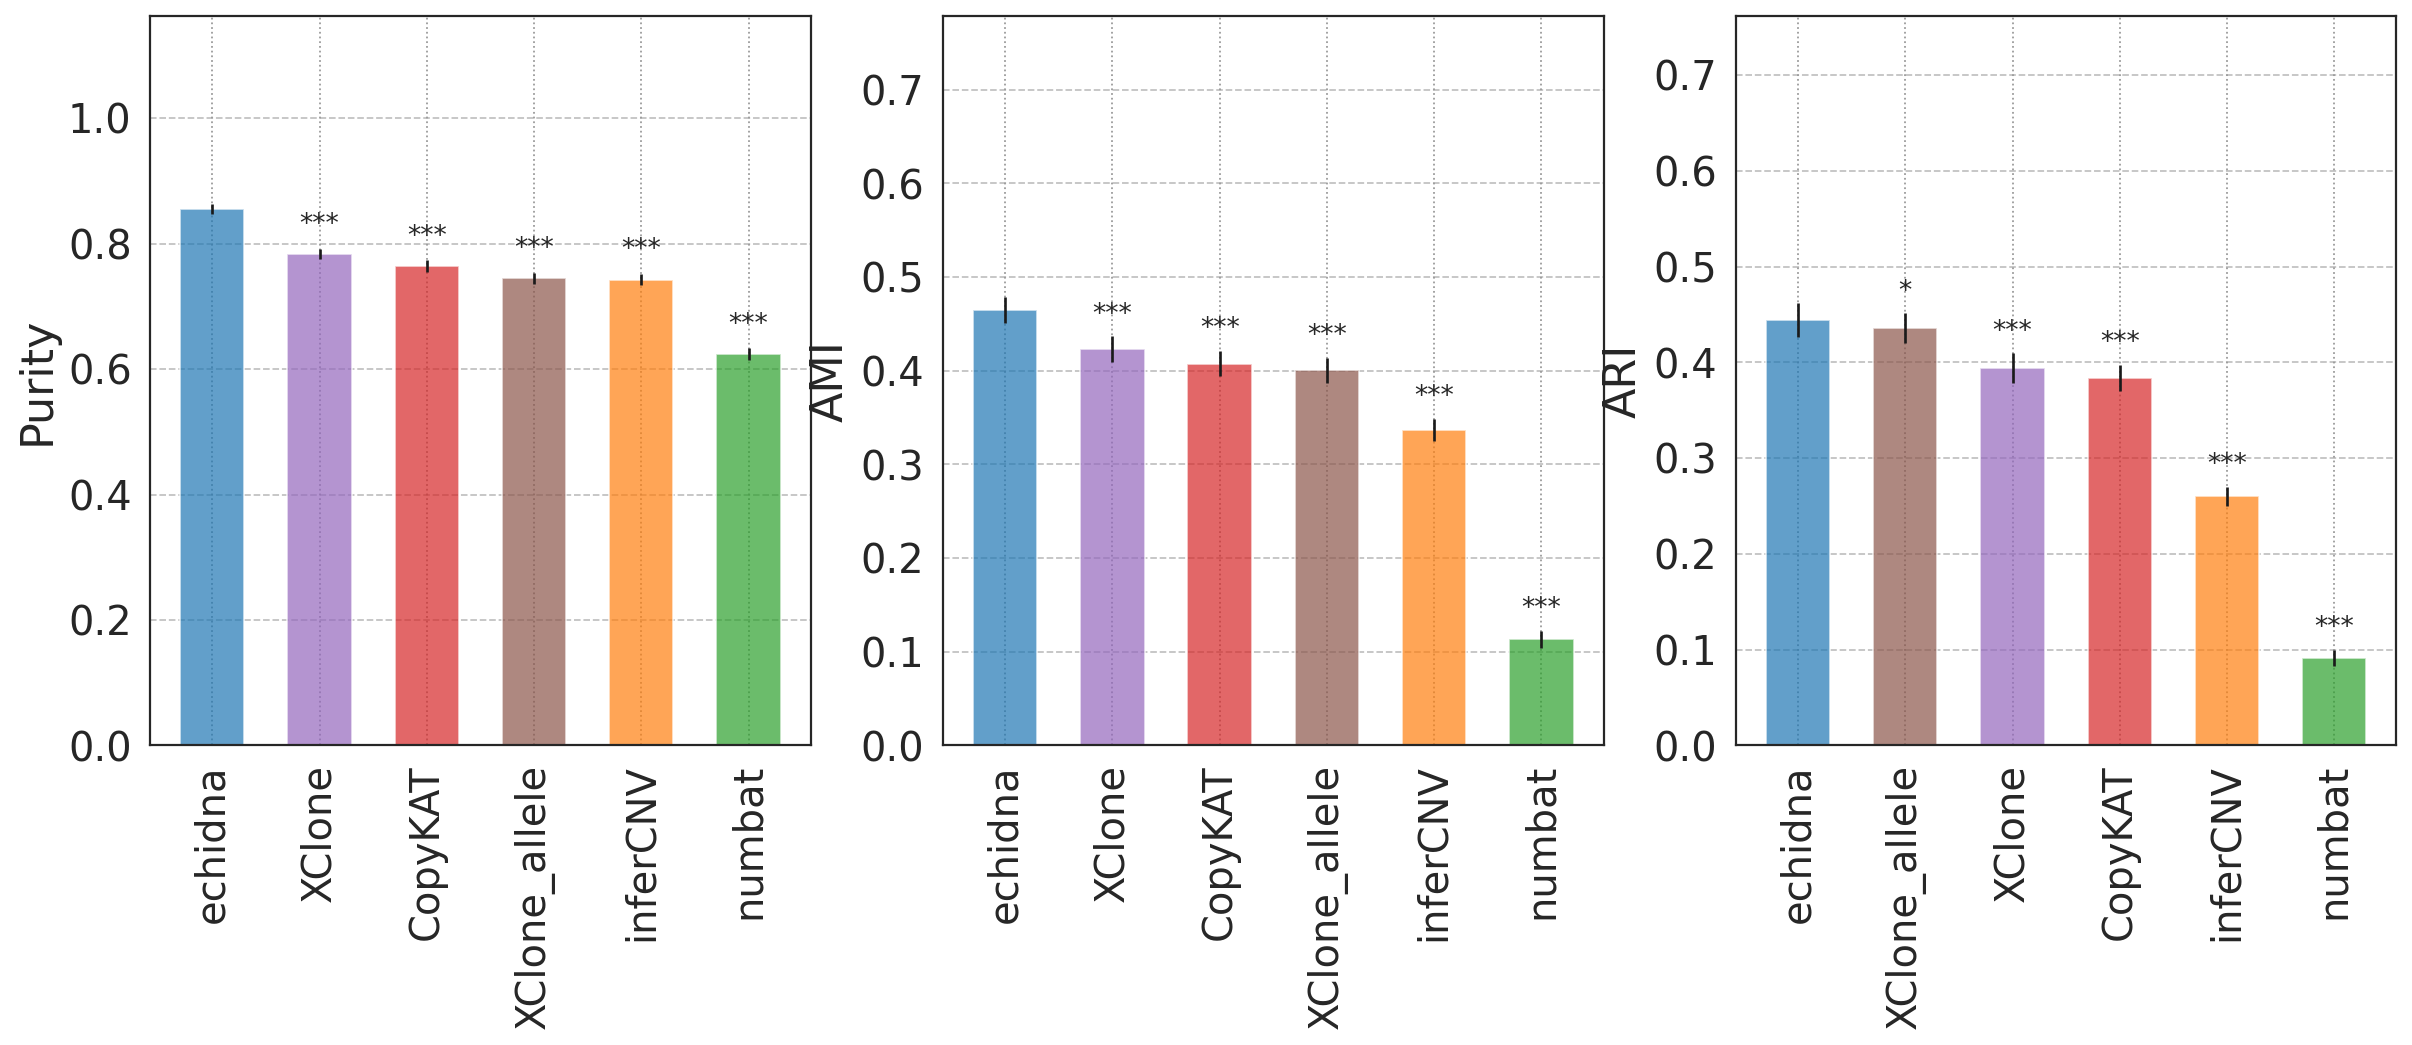

In [11]:
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_metric_bar(axes[0], 'Purity', metrics_adata1, [''], orientation='vertical')
plot_metric_bar(axes[1], 'AMI', metrics_adata1, [''], orientation='vertical')
plot_metric_bar(axes[2], 'ARI', metrics_adata1, [''], orientation='vertical')
plt.savefig("tumor2_clone_call_metrics.svg", format='svg', bbox_inches='tight', dpi=300)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor5.npy", xclone_binned)
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/copykat_binned_tumor5.npy", copykat_binned)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_copykat_tumor5.npy", DNA_cluster_copykat)
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor5.npy", DNA_cluster_xclone)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor2.npy", xclone_binned)
np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor2.npy", DNA_cluster_xclone)

In [70]:
sc.write("/home/mingxuanzhang/echidna/benchmarking_data/tumor2_echidna.h5ad", tumor2)

... storing 'inferCNV_clones' as categorical
... storing 'numbat_clones' as categorical
... storing 'CopyKAT_clones' as categorical
... storing 'XClone_clones' as categorical
... storing 'XClone_allele_clones' as categorical
